# Simulated data perspective rectification for processing DONKEY
This notebook changes the perspective of simulated data in folders processed_data

## Usage:
Run all cells

## Requirements:
./content/datasets/processed_data/sim_mask_retouched \  <- Manually modified data of sim_mask_cv
./content/datasets/processed_data/sim

## Outputs:
./content/datasets/processed_data/sim_rectified \
./content/datasets/processed_data/sim_rectified_mask_retouched

In [ ]:
import os

import re
from collections import OrderedDict
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.image as mpimg
from PIL import Image, ImageOps
import numpy as np
import cv2
import numpy as np
from skimage.metrics import structural_similarity as ssim
from scipy.spatial import KDTree
import matplotlib.pyplot as plt

In [35]:
def natural_sort_key(s):
    return [int(text) if text.isdigit() else text.lower() for text in re.split(r'(\d+)', s)]

def load_data_mask(images_folder):
  raw_image=[]
  image_files = sorted(os.listdir(images_folder),key=natural_sort_key)
  #print(image_files)    
  for image_file in image_files:
      if image_file[0]==".":
          break
      image = mpimg.imread(images_folder+image_file)
      if (image_file.split(".")[-1]=="png"):
          image = (image * 255).astype(np.uint8)
      raw_image.append(image)
  return raw_image

def load_data(images_folder):
  raw_image=[]
  image_files = sorted(os.listdir(images_folder),key=natural_sort_key) 
  for image_file in image_files:
      if image_file[0]!=".":
          image = mpimg.imread(images_folder+image_file)
          if (image_file.split(".")[-1]=="png"):
              image=image[:,:,:3]
              image = (image * 255).astype(np.uint8)
          raw_image.append(image)
  return raw_image

In [36]:
images_folder = f"./content/datasets/processed_data/sim_mask_retouched/"
raw_mask_sim=load_data_mask(images_folder)

images_folder = f"./content/datasets/processed_data/real_mask_retouched/"
raw_mask_real=load_data_mask(images_folder)


images_folder = f"./content/datasets/processed_data/sim/"
raw_image_sim=load_data(images_folder)

images_folder = f"./content/datasets/processed_data/real/"
raw_image_real=load_data(images_folder)

In [37]:
def rectify_sim(reference,img,plot):
  ysize = img.shape[0]
  xsize = img.shape[1]
  undist = img
  if(plot):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
  src = np.float32([
      (35,13),
      (xsize-35,13),
      (xsize-10,ysize),
      (10,ysize)
  ])
  src2=src.astype(np.int32)

  new_side=134
  new_height=0
  dst = np.float32([
      (0, 0),
      (xsize, 0),
      (xsize, ysize),
      (0, ysize)
      ])
  dst2=dst.astype(np.int32)

  isClosed = True
  color = (255, 0, 0)
  color2 = (255, 0, 0)
  thickness = 2
  undist2=undist.copy()
  undist2 = cv2.polylines(undist2, [src2],
                      isClosed, color, thickness)
  if(plot):
    axes[0].imshow(reference)
    axes[1].imshow(undist2)
  warped, M, invM = warp_image(undist, (xsize, ysize), src, dst)
  warped2=warped.copy()
  warped2 = cv2.polylines(warped2, [dst2],
                      isClosed, color2, thickness)
  if(plot):
    axes[2].imshow(warped)

  plt.show
  return warped
def warp_image(img, warp_shape, src, dst):

    # Get the perspective transformation matrix and its inverse
    M = cv2.getPerspectiveTransform(src, dst)
    invM = cv2.getPerspectiveTransform(dst, src)

    # Warp the image
    warped = cv2.warpPerspective(img, M, warp_shape, flags=cv2.INTER_AREA)
    return warped, M, invM

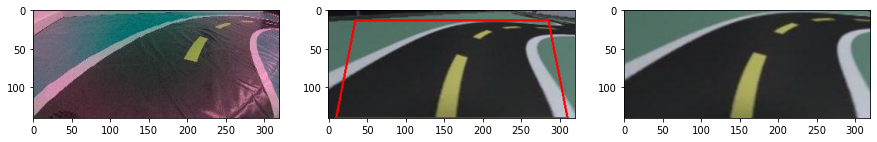

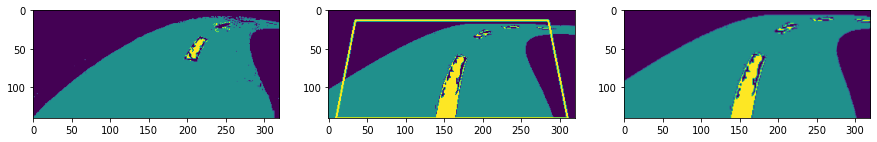

In [38]:
_=rectify_sim(raw_image_real[500],raw_image_sim[360],True)
_=rectify_sim(raw_mask_real[500],raw_mask_sim[360],True)

In [39]:
rectified_image_sim=[]
for raw_sim in raw_image_sim:
    rectified_image_sim.append(rectify_sim(raw_image_real[0],raw_sim,False))
rectified_mask_sim=[]
for raw_sim in raw_mask_sim:
    rectified_mask_sim.append(rectify_sim(raw_mask_real[0],raw_sim,False))

In [40]:
import tensorflow as tf
os.makedirs('./content/datasets/processed_data/sim_rectified/', exist_ok=True)
for i,image in enumerate(rectified_image_sim):
    png_image = tf.image.encode_png(image)
    with open('./content/datasets/processed_data/sim_rectified/image_'+str(i)+'.png', 'wb') as f:
      f.write(png_image.numpy())           

In [41]:
os.makedirs('./content/datasets/processed_data/sim_rectified_mask_retouched/', exist_ok=True)
for i,image in enumerate(rectified_mask_sim):
    png_image = tf.image.encode_png(tf.expand_dims(image, -1))
    with open('./content/datasets/processed_data/sim_rectified_mask_retouched/'+str(i)+'.png', 'wb') as f:
      f.write(png_image.numpy())